In [2]:
import numpy as np
import pandas as pd

# vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# finbert
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# nltk
import nltk

/Users/visheshgupta/miniforge3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/visheshgupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
gold_df = pd.read_csv("gold-dataset-sinha-khandait.csv")

In [5]:
gold_df["News"].iloc[10569]

'december gold down $1 at $749 an ounce on nymex'

# Understand the DATA

In [6]:
gold_df.columns

Index(['Dates', 'URL', 'News', 'Price Direction Up',
       'Price Direction Constant', 'Price Direction Down', 'Asset Comparision',
       'Past Information', 'Future Information', 'Price Sentiment'],
      dtype='object')

In [7]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10570 entries, 0 to 10569
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Dates                     10570 non-null  object
 1   URL                       10570 non-null  object
 2   News                      10570 non-null  object
 3   Price Direction Up        10570 non-null  int64 
 4   Price Direction Constant  10570 non-null  int64 
 5   Price Direction Down      10570 non-null  int64 
 6   Asset Comparision         10570 non-null  int64 
 7   Past Information          10570 non-null  int64 
 8   Future Information        10570 non-null  int64 
 9   Price Sentiment           10570 non-null  object
dtypes: int64(6), object(4)
memory usage: 825.9+ KB


In [8]:
gold_df.describe()

,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information
count,10570.000000,10570.000000,10570.000000,10570.000000,10570.000000,10570.00000
mean,0.417408,0.042006,0.370104,0.189309,0.969915,0.03018
std,0.493155,0.200612,0.482855,0.391773,0.170830,0.17109
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
50%,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


<Axes: xlabel='Price Sentiment'>

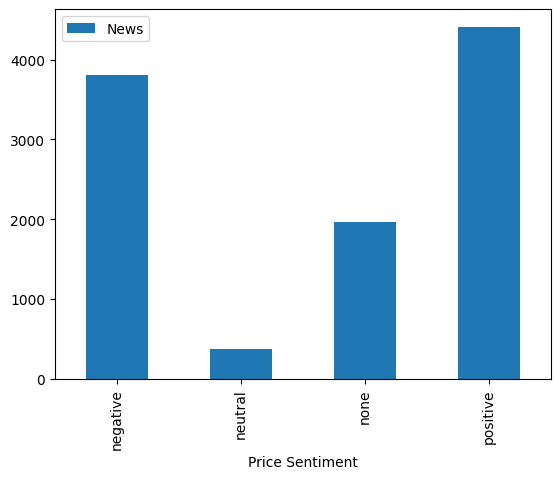

In [9]:
gold_df[["News", "Price Sentiment"]].groupby("Price Sentiment").count().plot(kind="bar")

In [10]:
# nuetral and none are the same thing
gold_df["Price Sentiment"] = np.where(
    gold_df["Price Sentiment"] == "none", "neutral", gold_df["Price Sentiment"]
)

In [12]:
gold_df.head(5)


,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative
1,13-09-2017,http://www.marketwatch.com/story/gold-prices-s...,gold suffers third straight daily decline,0,0,1,0,1,0,negative
2,26-07-2016,http://www.marketwatch.com/story/gold-futures-...,Gold futures edge up after two-session decline,1,0,0,0,1,0,positive
3,28-02-2018,https://www.metalsdaily.com/link/277199/dent-r...,dent research : is gold's day in the sun comin...,0,0,0,0,0,1,neutral
4,06-09-2017,http://www.marketwatch.com/story/gold-steadies...,"Gold snaps three-day rally as Trump, lawmakers...",0,0,1,0,1,0,negative


In [151]:
vader_analyzer = SentimentIntensityAnalyzer()


def vader_sentiment(clean_comment):
    if isinstance(clean_comment, str):
        sentiment = vader_analyzer.polarity_scores(clean_comment)
        return sentiment["compound"]
    return None

In [152]:
gold_df["VADER_sentiment"] = gold_df["News"].apply(vader_sentiment)
gold_df["original_sentiment"] = gold_df["Price Sentiment"]

In [153]:
# gold_df[["Dates", "News", "original_sentiment", "VADER_sentiment"]].to_csv("sentiment_gold_dataframe.csv")

In [154]:
gold_df["VADER_label"] = np.where(
    gold_df["VADER_sentiment"] > 0,
    "positive",
    np.where(gold_df["VADER_sentiment"] == 0, "neutral", "negative"),
)

In [155]:
gold_df[["original_sentiment", "VADER_label"]]

,original_sentiment,VADER_label
0,negative,neutral
1,negative,negative
2,positive,neutral
3,neutral,neutral
4,negative,positive
...,...,...
10565,negative,negative
10566,positive,positive
10567,negative,negative
10568,positive,neutral


In [156]:
gold_df["VADER_equal"] = np.where(
    gold_df["VADER_label"] == gold_df["Price Sentiment"], 1, 0
)

In [157]:
tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [158]:
def initialize_finbert():
    tokenizer = BertTokenizer.from_pretrained("ProsusAI/finbert")
    model = BertForSequenceClassification.from_pretrained("ProsusAI/finbert")
    return tokenizer, model


# Function to get sentiment probabilities
def get_sentiment(text, tokenizer, model):
    # Tokenize input text
    inputs = tokenizer(
        text, return_tensors="pt", padding=True, truncation=True, max_length=512
    )

    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)

    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    probs = probs.detach().numpy()[0]

    sentiment_labels = ["positive", "negative", "neutral"]
    pred_label = sentiment_labels[np.argmax(probs)]

    return pred_label, probs


# Function to process entire dataframe
def analyze_dataframe_sentiment(df, text_column="news"):

    # Initialize FinBERT
    tokenizer, model = initialize_finbert()

    # Create empty lists to store results
    sentiments = []
    positive_probs = []
    negative_probs = []
    neutral_probs = []

    for i, text in enumerate(df[text_column]):
        try:
            label, probs = get_sentiment(text, tokenizer, model)
            sentiments.append(label)
            positive_probs.append(probs[0])
            negative_probs.append(probs[1])
            neutral_probs.append(probs[2])

        except Exception as e:
            print(f"Error processing row {i}: {str(e)}")
            sentiments.append("error")
            positive_probs.append(np.nan)
            negative_probs.append(np.nan)
            neutral_probs.append(np.nan)

    df["sentiment"] = sentiments
    # df['positive_prob'] = positive_probs
    # df['negative_prob'] = negative_probs
    # df['neutral_prob'] = neutral_probs

    return df["sentiment"]

In [159]:
gold_df["Finbert_Sentiment"] = analyze_dataframe_sentiment(gold_df, text_column="News")

In [160]:
gold_df.head(1)

,Dates,URL,News,Price Direction Up,Price Direction Constant,Price Direction Down,Asset Comparision,Past Information,Future Information,Price Sentiment,VADER_sentiment,original_sentiment,VADER_label,VADER_equal,sentiment,Finbert_Sentiment
0,28-01-2016,http://www.marketwatch.com/story/april-gold-do...,"april gold down 20 cents to settle at $1,116.1...",0,0,1,0,1,0,negative,0.0,negative,neutral,0,negative,negative


In [161]:
gold_df["Finbert_Sentiment_equal"] = np.where(
    gold_df["Finbert_Sentiment"] == gold_df["Price Sentiment"], 1, 0
)

In [ ]:
# we need to set the seed to ensure that results will stay the same
gold_df["Finbert_Sentiment_equal"].sum()

8211

In [163]:
gold_df["Finbert_Sentiment_equal_VADER"] = np.where(
    gold_df["Finbert_Sentiment"] == gold_df["VADER_label"], 1, 0
)

In [164]:
gold_df["Finbert_Sentiment_equal_VADER"].sum()

4480

In [165]:
gold_df.columns

Index(['Dates', 'URL', 'News', 'Price Direction Up',
       'Price Direction Constant', 'Price Direction Down', 'Asset Comparision',
       'Past Information', 'Future Information', 'Price Sentiment',
       'VADER_sentiment', 'original_sentiment', 'VADER_label', 'VADER_equal',
       'sentiment', 'Finbert_Sentiment', 'Finbert_Sentiment_equal',
       'Finbert_Sentiment_equal_VADER'],
      dtype='object')

In [166]:
final_df = gold_df[
    [
        "Dates",
        "News",
        "Price Sentiment",
        "VADER_sentiment",
        "VADER_label",
        "VADER_equal",
        "Finbert_Sentiment",
        "Finbert_Sentiment_equal",
    ]
]

In [167]:
# OR logic -> we may want to change this.
"""
1. we could add a third approach of getting sentiment and apply that and do best of 2
2. maybe we weight them both with Finbert having higher say than VADER and then make a decision
Open to discussion
"""


def logical_or(row):
    x, y = row["VADER_label"], row["Finbert_Sentiment"]
    if "positive" in (x, y):
        return "positive"
    elif "negative" in (x, y):
        return "negative"
    else:
        return "neutral"


final_df["combined_result_VADER_&_Finbert"] = final_df.apply(logical_or, axis=1)

/var/folders/mc/2wjfdchj6vsffbrpfbfgqw4w0000gn/T/ipykernel_11855/3426729801.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["combined_result_VADER_&_Finbert"] = final_df.apply(logical_or, axis=1)


In [168]:
VADER_comparison = (
    np.where(final_df["VADER_label"] == final_df["Price Sentiment"], 1, 0).sum()
    / final_df.shape[0]
) * 100

FINBERT_comparison = (
    np.where(final_df["Finbert_Sentiment"] == final_df["Price Sentiment"], 1, 0).sum()
    / final_df.shape[0]
) * 100

combined_comparison = (
    np.where(
        final_df["combined_result_VADER_&_Finbert"] == final_df["Price Sentiment"], 1, 0
    ).sum()
    / final_df.shape[0]
) * 100

In [169]:
print(f"VADER gives us {VADER_comparison :.3f} to the pre defined sentiment")
print(f"\nFINBERT gives us {FINBERT_comparison :.3f} to the pre defined sentiment")
print(
    f"\nCombined sentiment gives us {combined_comparison :.3f} to the pre defined sentiment"
)

VADER gives us 41.892 to the pre defined sentiment

FINBERT gives us 77.682 to the pre defined sentiment

Combined sentiment gives us 73.415 to the pre defined sentiment
